# Atividade aula 4
Grupo composto:

Fabiano Thiele Fracassi, José Guilherme Koury, Ricardo Schmitt Martins, Roberto Emilio de Senna, Roberto Rodrigues Barbosa

In [3]:
import pandas as pd
import seaborn as sns
from bcb import sgs, currency, TaxaJuros

## Informe de Resultados do MGLU3

In [ ]:
## Importa os dados do google drive
bp = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTq_-oCydZOtrO1J_eMkG849ttZbQ_N4kLSOSFWKIuTwQZ9FMEHjN1mlzK4c_Ba9xLUNf6s67PhXf9F/pub?gid=86692319&single=true&output=csv',
               header=1)
dre = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTq_-oCydZOtrO1J_eMkG849ttZbQ_N4kLSOSFWKIuTwQZ9FMEHjN1mlzK4c_Ba9xLUNf6s67PhXf9F/pub?gid=2092096157&single=true&output=csv',
                    header=1)

In [ ]:
## Transforma os dados de forma a deixar um dataframe limpo para os cálculos
# Trabalha com o dataframe do Balanço Patrimonial
bpr = bp.transpose().iloc[:,[4,5,27]]
bpr.rename(columns={4:'clientes',5:'estoques',27:'fornecedores'},inplace=True)
bpr.drop(index='Unnamed: 0',inplace=True)
#display(bpr.head())

# Trabalha com o dataframe da DRE
drer = dre.transpose().iloc[:,[2,3]]
drer.rename(columns={2:'receita_liq',3:'custos'},inplace=True)
drer.drop(index=' ',inplace=True)
#display(drer.head())

# Combina os dois dataframes
df = pd.concat([bpr.transpose(),drer.transpose()]).transpose()
df = df.astype({'clientes':float,
                'estoques':float,
                'fornecedores':float,
                'receita_liq':float,
                'custos':float}) 
#display(df.head())

# Converte o índice das colunas em formato data
df = df.reset_index()
df = df.rename(columns={'index':'data'})
df['data']=pd.to_datetime(df['data'].astype(str), format='%d/%m/%Y')

In [ ]:
## Efetua os cálculos dos indicadores
df['custos']=abs(df['custos'])
df['pme'] = (df['estoques'] / df['custos']) * 90
df['pmr'] = (df['clientes'] / df['receita_liq']) * 90
df['pmp'] = (df['fornecedores'] / df['custos']) * 90
df['co'] = df['pme'] + df['pmr']
df['cc'] = df['co'] - df['pmp']
#df.head()

## Indicadores Complementares

Encontrar o Beta: https://br.financas.yahoo.com/

In [8]:
# Indicadores complementares
df2 = pd.read_csv('indicadores_complementares.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: 'indicadores_complementares.csv'

## Indicadores Financeiros do Banco Central

In [ ]:
# Busca a série da SELIC no SGS
selic = sgs.get({'selic':432}, start = '2012-01-01')
# Busca a série do IPCA e IGP-M
inflacao = sgs.get({'ipca':433, 'igp-m':189}, start = '2012-01-01')
# Transforma a frequência da data em mensal
inflacao.index = inflacao.index.to_period('M')
# Importas moedas 
moeda = currency.get(['USD', 'EUR'], start='2012-01-01', end='2022-11-16')
# Importa Taxa média de juros das operações de crédito - Pessoas jurídicas - Total - %a.a.
juros = sgs.get({'juros_aa':20715}, start = '2012-01-01')

In [ ]:
def adjust_format(df):
    df = df.sort_values('Date',ascending=False).reset_index()
    df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y-%m-%d')
    df['datenum'] = df['Date'].values.astype(float) / 1e10
    df.set_index(['datenum'], inplace=True)
    return df

In [ ]:
s=adjust_format(selic)
j=adjust_format(juros).drop('Date',axis=1)
m=adjust_format(moeda).drop('Date',axis=1)

In [ ]:
df3 = pd.concat([s, j, m], axis=1, join='outer')
df3['EUR']=df3['EUR'].fillna(method='ffill')
df3['USD']=df3['USD'].fillna(method='ffill')
df3['juros_aa']=df3['juros_aa'].fillna(method='bfill')
df3['juros_aa']=df3['juros_aa'].fillna(method='ffill')
df3

,Date,selic,juros_aa,EUR,USD
datenum,,,,,
166864320.0,2022-11-17,13.75,19.01,NaN,NaN
166855680.0,2022-11-16,13.75,19.01,5.5364,5.3204
166847040.0,2022-11-15,13.75,19.01,5.5364,5.3204
166838400.0,2022-11-14,13.75,19.01,5.4773,5.3013
166829760.0,2022-11-13,13.75,19.01,5.4773,5.3013
...,...,...,...,...,...
132572160.0,2012-01-05,11.00,19.06,2.3511,1.8371
132563520.0,2012-01-04,11.00,19.06,2.3677,1.8272
132554880.0,2012-01-03,11.00,19.06,2.4057,1.8457


## Calculando os indicadores
### ke we kd wd WACC e Lucro Econômico

In [ ]:
def drop_index(df):
    df = df.drop(df.index[[0]])
    return df

def unindex_series(df):
    df = df.reset_index(drop=True)
    df = df.astype(float)
    return df

In [ ]:
# Pegando as variáveis que precisamos para os cálculos intermediários
desp_fin = drop_index(dre.transpose().iloc[:,[13]])
emprestimos_cp = drop_index(bp.transpose().iloc[:,[29]])
emprestimos_lp = drop_index(bp.transpose().iloc[:,[36]])
pl = drop_index(bp.transpose().iloc[:,[45]])
ativo_total = drop_index(bp.transpose().iloc[:,[0]])

i = abs(desp_fin[13]) / (emprestimos_cp[29] + emprestimos_lp[36])
i_ano = ((1 + i)**4)-1
kd = i_ano*(1-.34)
ke = df2['rf'] + df2['beta']*(df2['rm'] + df2['rf'])
we = pl[45] / ativo_total[0]
wd = 1 - we

# Desindexando as series e convertendo em float
kd = unindex_series(kd)
ke = unindex_series(ke)
wd = unindex_series(wd)
we = unindex_series(we)

wacc = (we*ke)+(wd*kd)
receita_liq = unindex_series(drer['receita_liq'])
custos = unindex_series(drer['custos'])

receita_liq_pv = receita_liq / ((1 + wacc)**(df['co']/360))
custos_pv = custos / ((1 + wacc)**(df['pmp']/360))
lucro_economico = receita_liq_pv + custos_pv

In [ ]:
# Inclui os dados no dataset
df['ke'] = ke
df['we'] = we
df['kd'] = kd
df['wd'] = wd
df['wacc'] = wacc
df['lucro_economico'] = lucro_economico
df['ipca'] = df2['ipca']
df['igpm'] = df2['igpm']
df['dolar'] = df2['dolar']
df['euro'] = df2['euro']
df['pib'] = df2['pib']
df['juros'] = df2['juros']
df.head()

,data,clientes,estoques,fornecedores,receita_liq,custos,pme,pmr,pmp,co,...,kd,wd,wacc,lucro_economico,ipca,igpm,dolar,euro,pib,juros
0,2022-06-30,5621703.0,7965704.0,7380799.0,8562389.0,6109614.0,117.341842,59.090199,108.725676,176.432041,...,0.288341,0.682970,0.279131,1.917382e+06,0.022,0.024,0.106,0.043,0.012,0.265
1,2022-03-31,4801071.0,8077255.0,6248478.0,8762175.0,6330426.0,114.834760,49.313828,88.834941,164.148588,...,0.274004,0.670680,0.296996,1.845480e+06,0.032,0.055,-0.151,-0.168,0.047,0.244
2,2021-12-31,5650759.0,9112214.0,10098944.0,9399998.0,7025695.0,116.728560,54.103023,129.368690,170.831583,...,0.185837,0.706621,0.226392,2.003488e+06,0.030,0.015,0.026,0.004,0.046,0.225
3,2021-09-30,5427841.0,8126343.0,9177531.0,8612033.0,6877900.0,106.336363,56.723620,120.091567,163.059983,...,0.344317,0.644101,0.328677,1.316051e+06,0.030,0.008,0.087,0.063,0.039,0.215
4,2021-06-30,3779102.0,7496866.0,8241821.0,9013308.0,6705039.0,100.628489,37.735222,110.627826,138.363711,...,0.381576,0.710143,0.353458,1.913969e+06,0.017,0.063,-0.122,-0.114,0.019,0.212


In [ ]:
df['lucro_economico'].map('{:,.0f}'.format)

0     1,917,382
1     1,845,480
2     2,003,488
3     1,316,051
4     1,913,969
5     1,671,859
6     2,243,481
7     1,901,916
8     1,182,762
9     1,124,995
10    1,541,771
11    1,270,450
12      934,527
13      868,731
14    1,031,965
15      894,352
16      926,610
17      935,363
18      968,812
19      843,917
20      788,451
21      775,766
22      810,610
23      662,828
24      629,755
25      637,730
26      692,624
27      561,970
28      568,092
29      558,983
30      712,904
31      627,029
32      587,915
33      581,479
34      627,367
35      541,098
36      509,669
37      476,959
38      475,619
39      594,251
40      579,149
41      551,060
Name: lucro_economico, dtype: object

## Gerando matriz de correlações

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\fabia\AppData\Local\Temp\ipykernel_4112\2092377324.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot:>

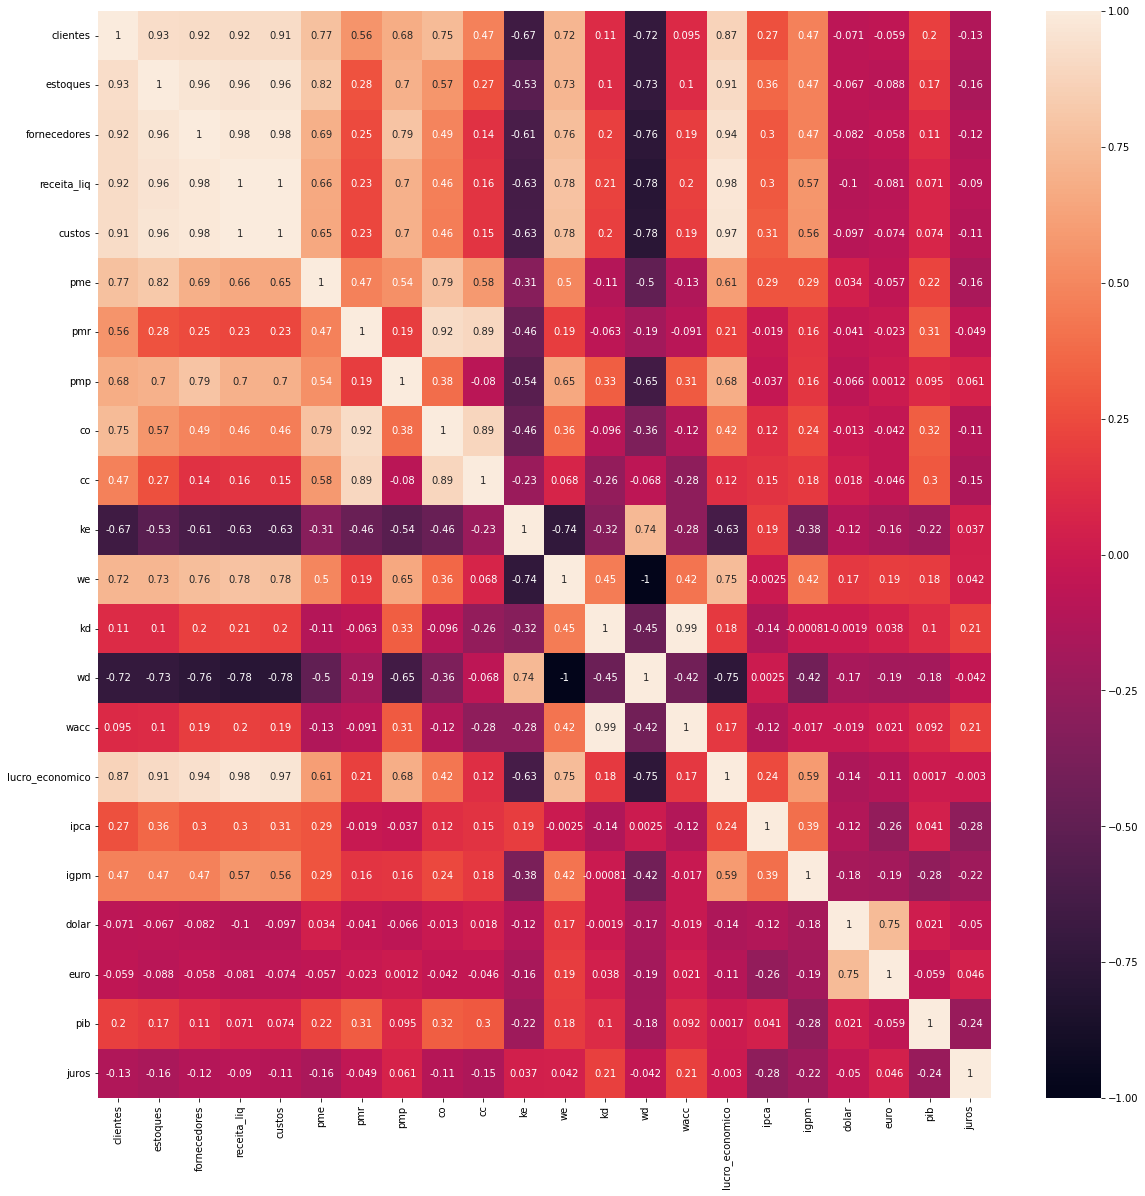

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2g', ax=ax)

In [ ]:
corr

,clientes,estoques,fornecedores,receita_liq,custos,pme,pmr,pmp,co,cc,...,kd,wd,wacc,lucro_economico,ipca,igpm,dolar,euro,pib,juros
clientes,1.000000,0.929217,0.919275,0.915754,0.914501,0.773846,0.559037,0.677026,0.745163,0.470278,...,0.106371,-0.721802,0.095490,0.872729,0.273100,0.472304,-0.071162,-0.058911,0.196965,-0.128419
estoques,0.929217,1.000000,0.964067,0.960923,0.961653,0.815369,0.280082,0.696918,0.568694,0.270014,...,0.104630,-0.725906,0.102033,0.912141,0.359562,0.473537,-0.066800,-0.087784,0.173114,-0.160692
fornecedores,0.919275,0.964067,1.000000,0.978825,0.982670,0.688398,0.249528,0.792286,0.489287,0.137275,...,0.199048,-0.764383,0.190191,0.939659,0.295233,0.473748,-0.081875,-0.058033,0.110131,-0.117038
receita_liq,0.915754,0.960923,0.978825,1.000000,0.998594,0.658711,0.232502,0.699588,0.463797,0.155487,...,0.211958,-0.783780,0.204919,0.976297,0.301762,0.565756,-0.103830,-0.080746,0.071332,-0.090156
custos,0.914501,0.961653,0.982670,0.998594,1.000000,0.654569,0.227023,0.699219,0.458066,0.149484,...,0.201102,-0.779297,0.194792,0.966289,0.313173,0.561719,-0.097022,-0.073660,0.074321,-0.109301
pme,0.773846,0.815369,0.688398,0.658711,0.654569,1.000000,0.469440,0.540699,0.785700,0.581269,...,-0.113383,-0.498094,-0.127814,0.607645,0.287563,0.288834,0.034018,-0.056768,0.223307,-0.162642
pmr,0.559037,0.280082,0.249528,0.232502,0.227023,0.469440,1.000000,0.194514,0.915048,0.891618,...,-0.063072,-0.188884,-0.090540,0.207096,-0.019456,0.155939,-0.041071,-0.022912,0.313918,-0.048986
pmp,0.677026,0.696918,0.792286,0.699588,0.699219,0.540699,0.194514,1.000000,0.383273,-0.079592,...,0.325204,-0.650069,0.306853,0.684100,-0.036949,0.163641,-0.066228,0.001216,0.095159,0.060924
co,0.745163,0.568694,0.489287,0.463797,0.458066,0.785700,0.915048,0.383273,1.000000,0.890199,...,-0.095982,-0.359866,-0.121819,0.422670,0.117730,0.241193,-0.013235,-0.041984,0.321941,-0.108616
cc,0.470278,0.270014,0.137275,0.155487,0.149484,0.581269,0.891618,-0.079592,0.890199,1.000000,...,-0.263991,-0.067746,-0.282824,0.118740,0.145284,0.179593,0.018382,-0.045911,0.300517,-0.147273
